In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
import cProfile


from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [3]:
def compute_average_spec_state(base_folder,local_path = 'Rat08/Rat08-20130713',*args):
    print(args)
    if args:
        stru = args[0]
        plot = args[1]
    
    bk.load.current_session_linux(base_folder = base_folder,local_path = local_path)
    
    print('Stru set to ',stru)
    states = bk.load.states()
    pos = bk.load.pos_csv()
    speed = bk.compute.old_speed(pos,20)
    
    low_velocity = bk.compute.toIntervals(speed.index,speed.values<2)
    quiet_wake = states['wake'].intersect(low_velocity)
    quiet_wake = quiet_wake.merge_close_intervals(0.2,time_units = 's')
    quiet_wake = quiet_wake.drop_short_intervals(5,time_units = 's')

    states.update({'quiet_wake':quiet_wake})
    runintervals = bk.load.run_intervals()
    states.update({'run':runintervals})
    del states['drowsy'],states['wake']
    
    
    chan = bk.load.random_channel(stru)
    
    lfps = {}
    for s,interval in states.items():
        lfps.update({s:bk.load.lfp_in_intervals(chan,interval)})

    power_spectrum = {}
    for s,l in lfps.items():
        f,spec = scipy.signal.welch(l.values,fs=1250,nperseg=5000,noverlap=2500)
        power_spectrum.update({s:(f,spec)})
        
    if plot == True:
        plt.figure()
        for s,spec in power_spectrum.items():
            plot_power_spectrum(spec[0],spec[1],[0,100],True)
        plt.legend(power_spectrum.keys())
    
    return power_spectrum

In [4]:
def flatten_spectrum(freqs,spectrum,freq_range):
    fm = FOOOF()
    fm.fit(freqs,spectrum,freq_range)
    init_ap_fit = init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
    init_flat_spec = fm.power_spectrum - init_ap_fit

    return fm.freqs, init_flat_spec

In [5]:
def plot_power_spectrum(t,spec,xlim,log = True):
    if log: 
        plt.loglog(t,spec)
        plt.xlim(xlim)
    
def plot_average_power_spectrum(power,stru):
    col = ['orange','black','green','red']
    for (s,spec),c in zip(power.items(),col):
        f = spec[0]
        spec = spec[1]

        log_spec = np.log(spec)
        mean_log_spec = np.mean(log_spec,0)
        std_log_spec = np.std(log_spec,0)


        plt.semilogx(f,mean_log_spec,f'{c}')
#         plt.plot(f,mean_log_spec+std_log_spec,f'{c}',linestyle='dashed')
#         plt.plot(f,mean_log_spec-std_log_spec,f'{c}',linestyle='dashed')
        plt.fill_between(f,mean_log_spec+std_log_spec,mean_log_spec-std_log_spec,color=c,alpha = 0.2)
        plt.xlim([0,100])
        plt.ylim([2.5,13])
    plt.legend(power.keys())
    plt.xlabel('Frequency Hz')
    plt.ylabel('Power Spectrum(log)')
    plt.title(f'Power Spectrum In the {stru} \n n_session = {len(spec)}')


def plot_average_power_spectrum_FOOF(power,stru):
    freq_range = [2,100]
    col = ['orange','black','green','red']
    for (s,spec),c in zip(power.items(),col):
        f = spec[0]
        spec = spec[1]
        spec_flat = []
        print(f)
        for u_spec in spec:
            f_flat,tmp_spec = flatten_spectrum(f,u_spec,freq_range)
            spec_flat.append(tmp_spec)

        mean_spec = np.mean(spec_flat,0)
        std_spec = np.std(spec_flat,0)


        plt.plot(f_flat,mean_spec,f'{c}')
#         plt.plot(f,mean_log_spec+std_log_spec,f'{c}',linestyle='dashed')
#         plt.plot(f,mean_log_spec-std_log_spec,f'{c}',linestyle='dashed')
        plt.fill_between(f_flat,mean_spec+std_spec,mean_spec-std_spec,color=c,alpha = 0.2)
        plt.xlim([0,100])
        # plt.ylim([2.5,13])
    plt.legend(power.keys())
    plt.xlabel('Frequency Hz')
    plt.ylabel('Power Spectrum(log)')
    plt.title(f'Power Spectrum In the {stru} \n n_session = {len(spec)}')

In [6]:
def merge(spec):
    states = ['Rem','sws','quiet_wake','run']
    power_spectrum = {}
    for s in states:
        av = []
        for sess,power_spec in spec.items():
            av.append(power_spec[s][1])
            power_spectrum.update({s:(power_spec[s][0],av)})
    return power_spectrum

In [7]:
args = ['Hpc',False]
average_spec_state_hpc = bk.load.batch(compute_average_spec_state,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light',*args)
args = ['BLA',False]
average_spec_state_bla = bk.load.batch(compute_average_spec_state,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light',*args)

  3%|▎         | 2/61 [08:03<3:59:10, 243.23s/it]

Loading Data from Rat08-20130710
('Hpc', False)
Rat : 8 on day : 3
Working with session Rat08-20130710 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130710
Stru set to  Hpc


In [36]:
power_hpc = merge(average_spec_state_hpc)
power_bla = merge(average_spec_state_bla)

[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]


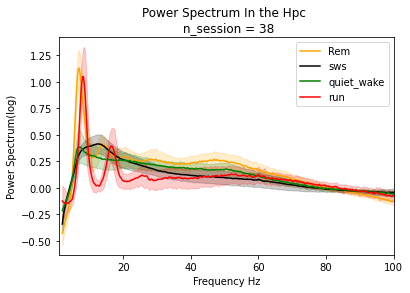

[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]
[0.0000e+00 2.5000e-01 5.0000e-01 ... 6.2450e+02 6.2475e+02 6.2500e+02]


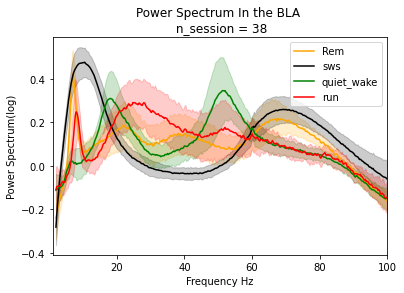

In [38]:
plt.figure()
plot_average_power_spectrum_FOOF(power_hpc,'Hpc')
plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/PowerSpectrum/Flatten/average_hpc_power_spec.svg')
plt.xlim(1,100)
plt.show()
plt.figure()
plot_average_power_spectrum_FOOF(power_bla,'BLA')
plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/PowerSpectrum/Flatten/average_bla_power_spec.svg')
plt.xlim(1,100)
plt.show()